# Structure and Surprise in Lana Del Rey’s Lyrics and Poetry

This notebook analyzes song lyrics and poetry using lexical, structural,
and phonetic features. We compare albums across a structure–surprise
space and examine how sound-based structure operates differently in poetry.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
ALBUM_YEARS = {
    # Lana Del Rey albums
    "aka_lizzy_grant": 2010,
    "born_to_die": 2012,
    "ultraviolence": 2014,
    "honeymoon": 2015,
    "lust_for_life": 2017,
    "nfr": 2019,
    "chemtrails_over_the_country_club": 2021,
    "blue_banisters": 2021,
    "did_you_know_ocean_blvd": 2023,
    "newest": 2026,

    # Tove Lo Albums
    "queen_of_the_clouds": 2014,
    "lady_wood": 2016,
    "blue_lips": 2017,
    "sunshine_kitty": 2019,
    "dirt_femme": 2022,

    # Stevie Nicks/Fleetwood Mac Albums
    "rumours": 1977,
    "say_you_will": 2003,
    "street_angel": 1994,

    "aurora": 2023,

    # Halsey Albums
    "badlands": 2015,
    "hopeless_fountain_kingdom": 2017,
    "manic": 2020,
    "if_i_cant_have_love_i_want_power": 2021,
    "the_great_impersonator": 2024,

    # Glass Animals Albums
    "zaba": 2014,
    "how_to_be_a_human_being": 2016,
    "dreamland": 2020,
    "ilysfm": 2024,

    # Marina Albums
    "the_family_jewels": 2010,
    "electra_heart": 2012,
    "froot": 2015,
    "love+fear": 2019,
    "ancient_dreams_in_a_modern_land": 2021,
    "princess_of_power": 2025,

    # Poetry
    "ariel": 1965,
    "violet_bent_backwards_over_the_grass": 2020,
    "ocean_vuong_poetry": 2019,
    "my_poetry": 2025,
    "the_colossus": 1960
}


In [37]:


# 1) Load the features table (adjust path if needed)
df = pd.read_csv("../data/features/song_features.csv")

# 2) Define which "albums" are actually poetry collections
POETRY_ALBUMS = {
    "ariel",
    "violet_bent_backwards_over_the_grass",
    "my_poetry",
    "ocean_vuong_poetry",
    "the_colossus",
}

LANA_ALBUMS = {
    "aka_lizzy_grant",
    "born_to_die",
    "ultraviolence",
    "honeymoon",
    "lust_for_life",
    "nfr",
    "chemtrails_over_the_country_club",
    "blue_banisters",
    "did_you_know_ocean_blvd",
    "newest",
}

TOVE_LO_ALBUMS = {
    "queen_of_the_clouds",
    "lady_wood",
    "blue_lips",
    "sunshine_kitty",
    "dirt_femme",
}

STEVIE_ALBUMS = {
    "rumours",
    "say_you_will",
    "street_angel",
    "aurora",
}

HALSEY_ALBUMS = {
    "badlands",
    "hopeless_fountain_kingdom",
    "manic",
    "if_i_cant_have_love_i_want_power",
    "the_great_impersonator",
}

GLASS_ANIMALS_ALBUMS = {
     "zaba",
    "how_to_be_a_human_being",
    "dreamland",
    "ilysfm",
}

MARINA_ALBUMS = {
    "the_family_jewels",
    "electra_heart",
    "froot",
    "love+fear",
    "ancient_dreams_in_a_modern_land",
    "princess_of_power",
}

# 3) Ensure a text_type column exists (no KeyError ever again)
df["text_type"] = df["album"].apply(lambda a: "poem" if a in POETRY_ALBUMS else "song")



def classify_artist(album):
    if album in LANA_ALBUMS:
        return "lana"
    elif album in TOVE_LO_ALBUMS:
        return "tove lo"
    elif album in STEVIE_ALBUMS:
        return "stevie"
    elif album in HALSEY_ALBUMS:
        return "halsey"
    elif album in GLASS_ANIMALS_ALBUMS:
        return "glass animals"
    elif album in MARINA_ALBUMS:
        return "marina"
    else:
        return "other"

df["artist_group"] = df["album"].apply(classify_artist)

df["year"] = df["album"].map(ALBUM_YEARS)
df[["album", "year"]].drop_duplicates().sort_values("year")


# 4) Clean splits you can reuse everywhere
df_songs = df[df["text_type"] == "song"].copy()
df_poems = df[df["text_type"] == "poem"].copy()

df_lana = df_songs[df_songs["artist_group"] == "lana"]
df_stevie = df_songs[df_songs["artist_group"] == "stevie"]
df_halsey = df_songs[df_songs["artist_group"] == "halsey"]
df_tove_lo = df_songs[df_songs["artist_group"] == "tove lo"]
df_marina = df_songs[df_songs["artist_group"] == "marina"]
df_glass_animals = df_songs[df_songs["artist_group"] == "glass animals"]



# 5) Quick sanity checks (so you can trust it)
print(df["text_type"].value_counts())
print("Song albums:", sorted(df_songs["album"].unique()))
print("Poetry collections:", sorted(df_poems["album"].unique()))


text_type
song    413
poem     74
Name: count, dtype: int64
Song albums: ['aka_lizzy_grant', 'ancient_dreams_in_a_modern_land', 'aurora', 'back_to_black', 'badlands', 'blue_banisters', 'born_to_die', 'chemtrails_over_the_country_club', 'did_you_know_ocean_blvd', 'dreamland', 'electra_heart', 'froot', 'honeymoon', 'hopeless_fountain_kingdom', 'how_to_be_a_human_being', 'if_i_cant_have_love_i_want_power', 'ilysfm', 'love+fear', 'lust_for_life', 'manic', 'newest', 'nfr', 'princess_of_power', 'rumours', 'say_you_will', 'street_angel', 'the_family_jewels', 'the_great_impersonator', 'ultraviolence', 'zaba']
Poetry collections: ['ariel', 'my_poetry', 'ocean_vuong_poetry', 'the_colossus', 'violet_bent_backwards_over_the_grass']


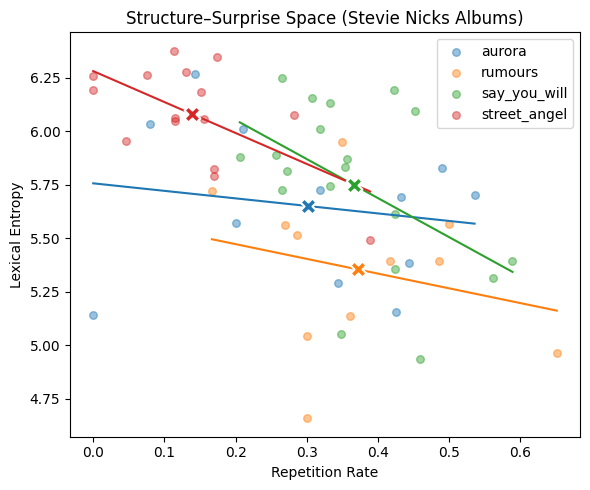

In [7]:
plt.figure(figsize=(6, 5))

for album in sorted(df_stevie["album"].unique()):
    sub = df_stevie[df_stevie["album"] == album]

    # scatter points
    plt.scatter(
        sub["repetition_rate"],
        sub["lexical_entropy"],
        s=30,
        alpha=0.45,
        label=album
    )

    # means (always safe)
    mean_x = sub["repetition_rate"].mean()
    mean_y = sub["lexical_entropy"].mean()

    if len(sub) > 1:
        x = sub["repetition_rate"].values
        y = sub["lexical_entropy"].values

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)

        line, = plt.plot(xs, m * xs + b)
        line_color = line.get_color()
    else:
        line_color = "black"

    # centroid X (matches line color)
    plt.scatter(
        mean_x,
        mean_y,
        marker="X",
        s=130,
        color=line_color,
        edgecolor="white",
        linewidth=1.5,
        zorder=6
    )

plt.xlabel("Repetition Rate")
plt.ylabel("Lexical Entropy")
plt.title("Structure–Surprise Space (Stevie Nicks Albums)")
plt.legend()
plt.tight_layout()
plt.show()


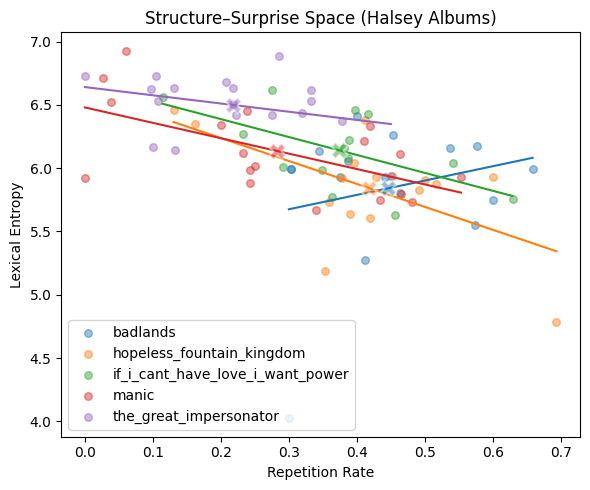

In [10]:
plt.figure(figsize=(6, 5))

for album in sorted(df_halsey["album"].unique()):
    sub = df_halsey[df_halsey["album"] == album]

    # scatter points
    plt.scatter(
        sub["repetition_rate"],
        sub["lexical_entropy"],
        s=30,
        alpha=0.45,
        label=album
    )

    # means (always safe)
    mean_x = sub["repetition_rate"].mean()
    mean_y = sub["lexical_entropy"].mean()

    if len(sub) > 1:
        x = sub["repetition_rate"].values
        y = sub["lexical_entropy"].values

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)

        line, = plt.plot(xs, m * xs + b)
        line_color = line.get_color()
    else:
        line_color = "black"

    # centroid X (matches line color)
    plt.scatter(
        mean_x,
        mean_y,
        marker="X",
        s=130,
        color=line_color,
        edgecolor="white",
        linewidth=1.5,
        zorder=6
    )

plt.xlabel("Repetition Rate")
plt.ylabel("Lexical Entropy")
plt.title("Structure–Surprise Space (Halsey Albums)")
plt.legend()
plt.tight_layout()
plt.show()


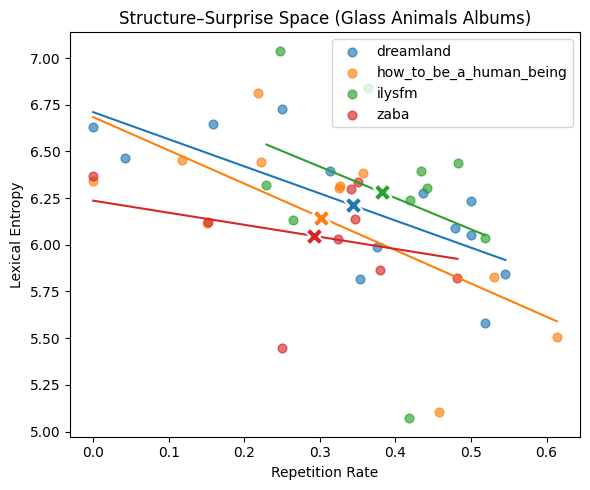

In [11]:
plt.figure(figsize=(6, 5))

for album in sorted(df_glass_animals["album"].unique()):
    sub = df_glass_animals[df_glass_animals["album"] == album]

    # scatter points
    plt.scatter(
        sub["repetition_rate"],
        sub["lexical_entropy"],
        s=40,
        alpha=0.65,
        label=album
    )

    # means (always safe)
    mean_x = sub["repetition_rate"].mean()
    mean_y = sub["lexical_entropy"].mean()

    if len(sub) > 1:
        x = sub["repetition_rate"].values
        y = sub["lexical_entropy"].values

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)

        line, = plt.plot(xs, m * xs + b)
        line_color = line.get_color()
    else:
        line_color = "black"

    # centroid X (matches line color)
    plt.scatter(
        mean_x,
        mean_y,
        marker="X",
        s=160,
        color=line_color,
        edgecolor="white",
        linewidth=1.5,
        zorder=6
    )

plt.xlabel("Repetition Rate")
plt.ylabel("Lexical Entropy")
plt.title("Structure–Surprise Space (Glass Animals Albums)")
plt.legend()
plt.tight_layout()
plt.show()


## Song Albums: Structure vs. Surprise

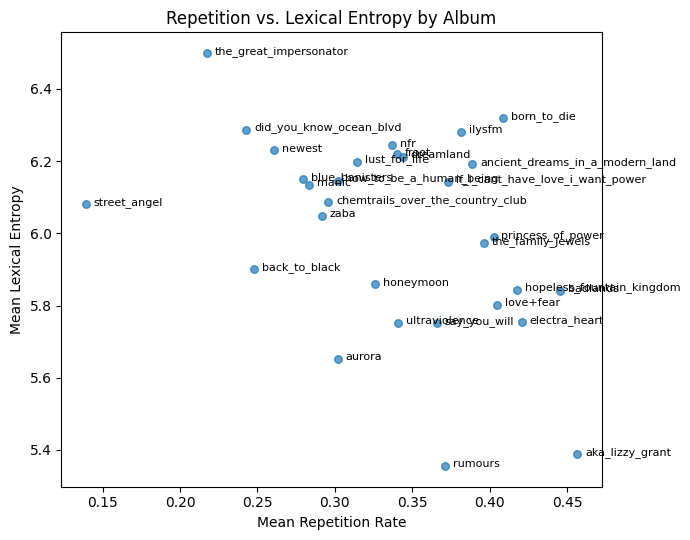

In [12]:
song_means = (
    df_songs
    .groupby("album")[["repetition_rate", "lexical_entropy"]]
    .mean()
    .reset_index()
)


plt.figure(figsize=(7, 5.5))
plt.scatter(
    song_means["repetition_rate"],
    song_means["lexical_entropy"],
    s=30,
    alpha=0.7,
)


for _, row in song_means.iterrows():
    plt.text(
        row["repetition_rate"] + 0.005,
        row["lexical_entropy"] + 0.005,
        row["album"],
        fontsize=8,
        ha="left",
        va="center"
    )

plt.xlabel("Mean Repetition Rate")
plt.ylabel("Mean Lexical Entropy")
plt.title("Repetition vs. Lexical Entropy by Album")
plt.tight_layout()
plt.show()


In [13]:
# pip install pronouncing

In [14]:
centroids = (
    df.groupby(["text_type", "album"], as_index=False)
      .agg({
          "phonetic_repetition_rate": "mean",
          "phonetic_entropy": "mean"
      })
)


## Poetry: Phonetic Structure vs Surprise


In [15]:
import pronouncing
import re

def get_phonetic_ending(word):
    phones = pronouncing.phones_for_word(word.lower())
    if not phones:
        return None

    # Take first pronunciation
    phonemes = phones[0].split()

    # Get last stressed vowel onward
    for i in range(len(phonemes) - 1, -1, -1):
        if phonemes[i][-1].isdigit():  # stress marker
            return tuple(phonemes[i:])
    return tuple(phonemes[-2:])


C:\Users\mahli\AppData\Local\Programs\Python\Python313\Lib\site-packages\pronouncing\__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


In [16]:
def phonetic_endings(text):
    endings = []
    for line in text.split("\n"):
        words = re.findall(r"\b\w+\b", line)
        if words:
            pe = get_phonetic_ending(words[-1])
            if pe:
                endings.append(pe)
    return endings


In [17]:
from collections import Counter

def phonetic_repetition_rate(endings):
    if not endings:
        return 0
    counts = Counter(endings)
    repeats = sum(c - 1 for c in counts.values() if c > 1)
    return repeats / len(endings)


In [18]:
import math

def phonetic_entropy(endings):
    if not endings:
        return 0
    counts = Counter(endings)
    total = sum(counts.values())
    probs = [c / total for c in counts.values()]
    return -sum(p * math.log2(p) for p in probs)


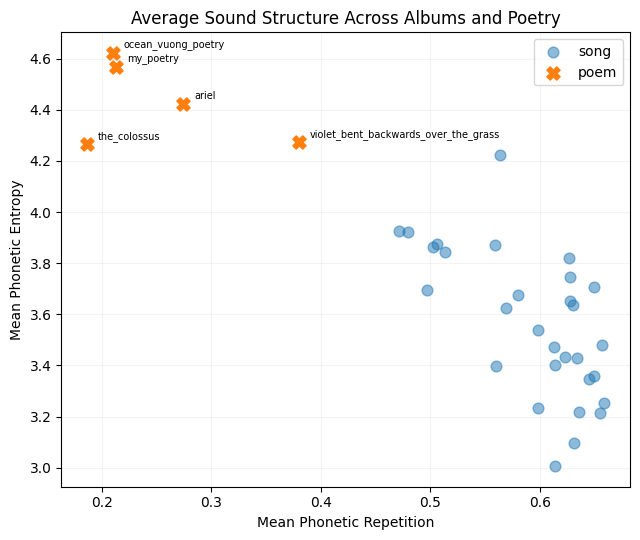

In [20]:


plt.figure(figsize=(6.5, 5.5))

# --- Songs (background) ---
songs = centroids[centroids["text_type"] == "song"]
plt.scatter(
    songs["phonetic_repetition_rate"],
    songs["phonetic_entropy"],
    s=60,
    alpha=0.5,
    color="tab:blue",
    label="song"
)

# --- Poems (foreground) ---
poems = centroids[centroids["text_type"] == "poem"]
plt.scatter(
    poems["phonetic_repetition_rate"],
    poems["phonetic_entropy"],
    s=90,
    marker="X",
    color="tab:orange",
    label="poem"
)

# Label ONLY poems
for _, row in poems.iterrows():
    plt.text(
        row["phonetic_repetition_rate"] + 0.01,
        row["phonetic_entropy"] + 0.02,
        row["album"],
        fontsize=7,
    )

plt.xlabel("Mean Phonetic Repetition")
plt.ylabel("Mean Phonetic Entropy")
plt.title("Average Sound Structure Across Albums and Poetry")

plt.legend()
plt.grid(alpha=0.15)
plt.tight_layout()
plt.show()


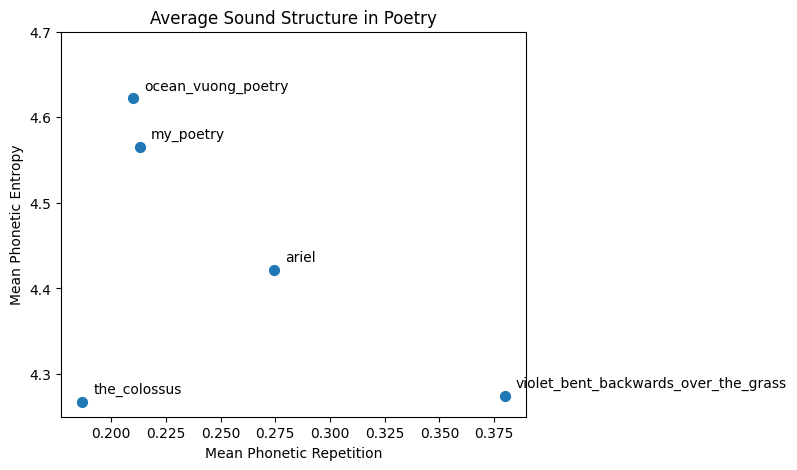

In [22]:


poem_means = (
    df_poems
    .groupby("album")[["phonetic_repetition_rate", "phonetic_entropy"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,5))

plt.scatter(
    poem_means["phonetic_repetition_rate"],
    poem_means["phonetic_entropy"],
    s=50
)

for _, row in poem_means.iterrows():
    plt.text(
        row["phonetic_repetition_rate"] + 0.005,
        row["phonetic_entropy"] + 0.01,
        row["album"],
        fontsize=10
    )



plt.xlabel("Mean Phonetic Repetition")
plt.ylabel("Mean Phonetic Entropy")
plt.ylim(4.25, 4.7)
plt.title("Average Sound Structure in Poetry")
plt.show()


In [23]:
# !pip install seaborn


In [24]:
import numpy as np
import pandas as pd

FEATURES = [
    "repetition_rate",
    "lexical_entropy",
    "phonetic_repetition_rate",
    "phonetic_entropy",
    "line_end_similarity",
    "first_person_rate",
    "second_person_rate",
    "third_person_rate",
]

def add_within_album_z(df, features=FEATURES):
    out = df.copy()
    for f in features:
        mu = out.groupby("album")[f].transform("mean")
        sd = out.groupby("album")[f].transform("std").replace(0, np.nan)
        out[f"{f}_z"] = (out[f] - mu) / sd
    return out

dfz = add_within_album_z(df_songs)


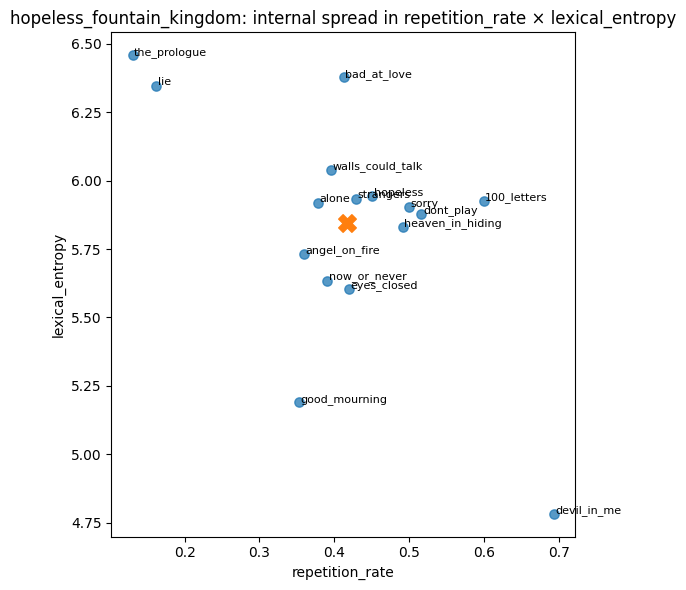

In [30]:
import matplotlib.pyplot as plt

def plot_album_cloud(df, album, x="repetition_rate", y="lexical_entropy",
                     label_col="song", alpha=0.75, s=45):
    sub = df[df["album"] == album].dropna(subset=[x, y]).copy()

    plt.figure(figsize=(6,6))
    plt.scatter(sub[x], sub[y], s=s, alpha=alpha)

    # centroid
    cx, cy = sub[x].mean(), sub[y].mean()
    plt.scatter([cx], [cy], marker="X", s=160)

    # light labels
    for _, r in sub.iterrows():
        plt.text(r[x] + 0.002, r[y] + 0.002, str(r[label_col]).replace(".txt","")[:18], fontsize=8)

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{album}: internal spread in {x} × {y}")
    plt.tight_layout()
    plt.show()

plot_album_cloud(dfz, "hopeless_fountain_kingdom")


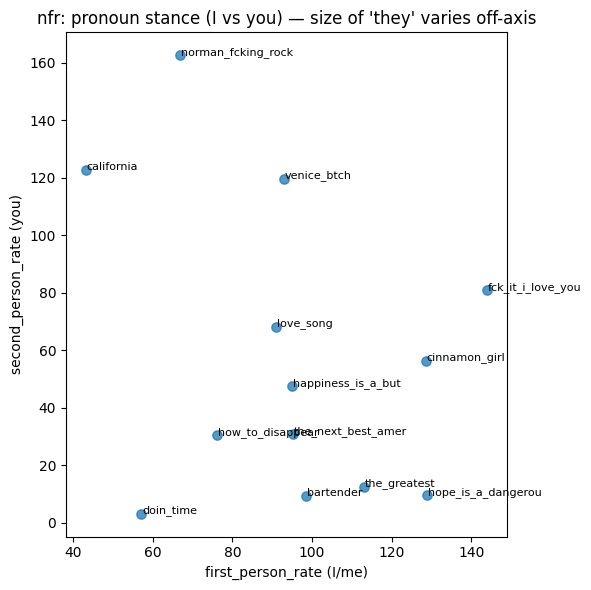

In [31]:
def plot_pronoun_stance(df, album):
    sub = df[df["album"] == album].dropna(subset=["first_person_rate","second_person_rate","third_person_rate"]).copy()

    plt.figure(figsize=(6,6))
    plt.scatter(sub["first_person_rate"], sub["second_person_rate"], alpha=0.75, s=45)

    # annotate lightly
    for _, r in sub.iterrows():
        plt.text(r["first_person_rate"]+0.2, r["second_person_rate"]+0.2,
                 str(r["song"]).replace(".txt","")[:18], fontsize=8)

    plt.xlabel("first_person_rate (I/me)")
    plt.ylabel("second_person_rate (you)")
    plt.title(f"{album}: pronoun stance (I vs you) — size of 'they' varies off-axis")
    plt.tight_layout()
    plt.show()

plot_pronoun_stance(dfz, "nfr")


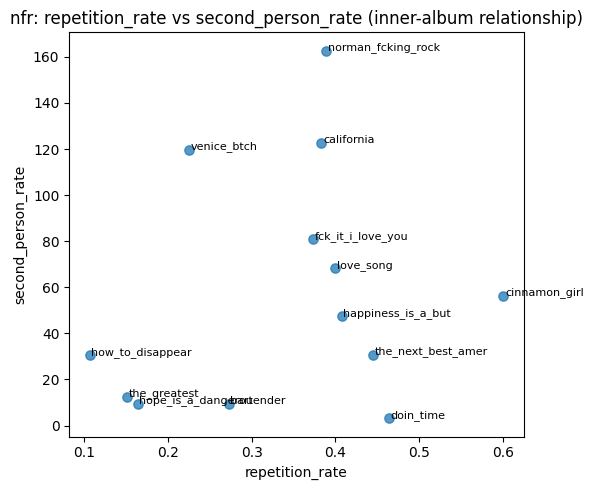

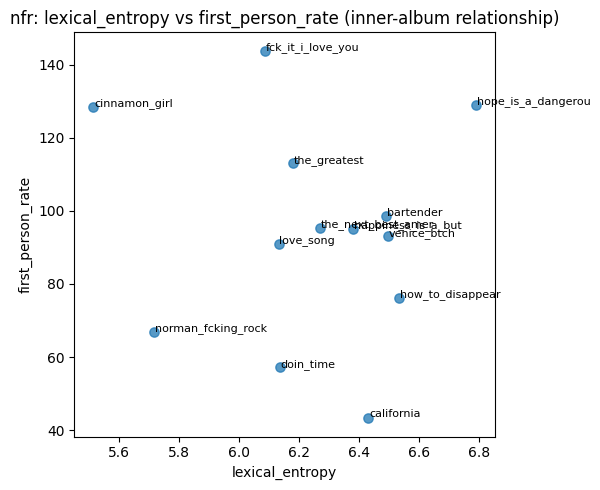

In [32]:
def plot_structure_vs_stance(df, album, x="repetition_rate", y="second_person_rate"):
    sub = df[df["album"] == album].dropna(subset=[x,y]).copy()

    plt.figure(figsize=(6,5))
    plt.scatter(sub[x], sub[y], alpha=0.75, s=45)
    for _, r in sub.iterrows():
        plt.text(r[x]+0.002, r[y]+0.2, str(r["song"]).replace(".txt","")[:18], fontsize=8)

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{album}: {x} vs {y} (inner-album relationship)")
    plt.tight_layout()
    plt.show()

plot_structure_vs_stance(dfz, "nfr", x="repetition_rate", y="second_person_rate")
plot_structure_vs_stance(dfz, "nfr", x="lexical_entropy", y="first_person_rate")


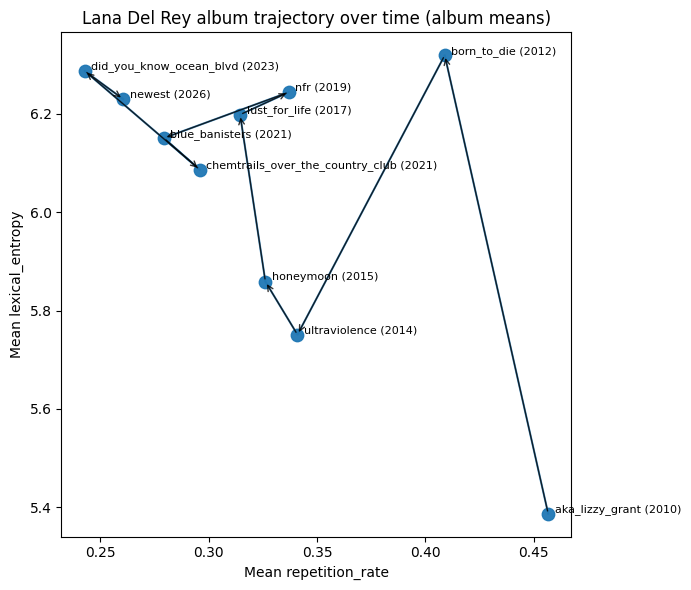

,album,year
0,aka_lizzy_grant,2010.0
2,born_to_die,2012.0
9,ultraviolence,2014.0
5,honeymoon,2015.0
6,lust_for_life,2017.0
8,nfr,2019.0
1,blue_banisters,2021.0
3,chemtrails_over_the_country_club,2021.0
4,did_you_know_ocean_blvd,2023.0
7,newest,2026.0


In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# assumes you already did:
# df["text_type"] = ...
# df["artist_group"] = df["album"].apply(classify_artist)

def plot_lana_album_trajectory(df,
                              x="repetition_rate",
                              y="lexical_entropy",
                              album_col="album",
                              year_col="year",
                              artist_col="artist_group",
                              label_col="album",
                              show_arrows=True,
                              annotate=True):

    lana = df.copy()
    lana = lana[lana[artist_col] == "lana"].dropna(subset=[album_col, year_col, x, y])

    lana[year_col] = pd.to_numeric(lana[year_col], errors="coerce")
    lana = lana.dropna(subset=[year_col])

    # album-level means (one point per album)
    album_means = (
        lana.groupby([album_col, year_col])[[x, y]]
            .mean()
            .reset_index()
            .sort_values([year_col, album_col])
    )

    plt.figure(figsize=(7, 6))

    # points + connecting path
    plt.scatter(album_means[x], album_means[y], s=80, alpha=0.95)
    plt.plot(album_means[x].values, album_means[y].values, alpha=0.8)

    # arrows for direction
    if show_arrows and len(album_means) >= 2:
        for i in range(len(album_means) - 1):
            x0, y0 = album_means.iloc[i][x], album_means.iloc[i][y]
            x1, y1 = album_means.iloc[i+1][x], album_means.iloc[i+1][y]
            plt.annotate("", xy=(x1, y1), xytext=(x0, y0),
                         arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8))

    # labels
    if annotate:
        for _, r in album_means.iterrows():
            yr = int(r[year_col])
            plt.text(r[x] + 0.003, r[y] + 0.003, f"{r[label_col]} ({yr})", fontsize=8)

    plt.xlabel(f"Mean {x}")
    plt.ylabel(f"Mean {y}")
    plt.title("Lana Del Rey album trajectory over time (album means)")
    plt.tight_layout()
    plt.show()

    return album_means

lana_album_means = plot_lana_album_trajectory(df)
lana_album_means[["album", "year"]]



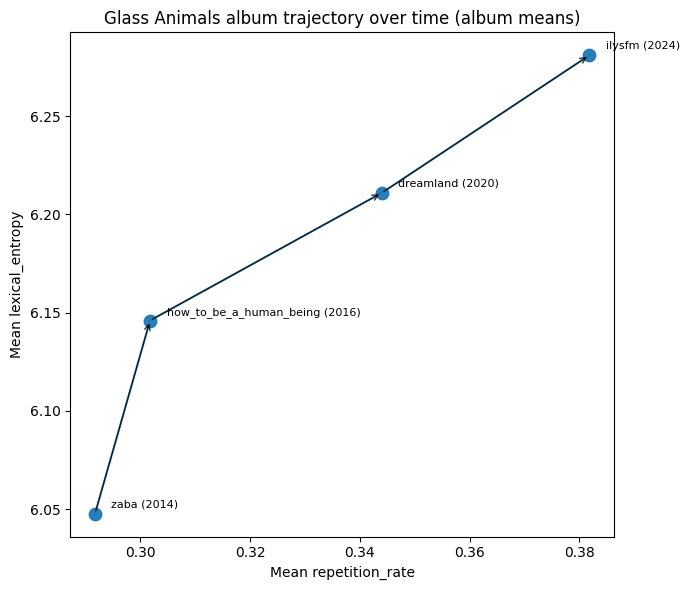

,album,year
3,zaba,2014.0
1,how_to_be_a_human_being,2016.0
0,dreamland,2020.0
2,ilysfm,2024.0


In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# assumes you already did:
# df["text_type"] = ...
# df["artist_group"] = df["album"].apply(classify_artist)

def plot_glass_animals_trajectory(df,
                              x="repetition_rate",
                              y="lexical_entropy",
                              album_col="album",
                              year_col="year",
                              artist_col="artist_group",
                              label_col="album",
                              show_arrows=True,
                              annotate=True):

    glass_animals = df.copy()
    glass_animals = glass_animals[glass_animals[artist_col] == "glass animals"].dropna(subset=[album_col, year_col, x, y])

    glass_animals[year_col] = pd.to_numeric(glass_animals[year_col], errors="coerce")
    glass_animals = glass_animals.dropna(subset=[year_col])

    # album-level means (one point per album)
    album_means = (
        glass_animals.groupby([album_col, year_col])[[x, y]]
            .mean()
            .reset_index()
            .sort_values([year_col, album_col])
    )

    plt.figure(figsize=(7, 6))

    # points + connecting path
    plt.scatter(album_means[x], album_means[y], s=80, alpha=0.95)
    plt.plot(album_means[x].values, album_means[y].values, alpha=0.8)

    # arrows for direction
    if show_arrows and len(album_means) >= 2:
        for i in range(len(album_means) - 1):
            x0, y0 = album_means.iloc[i][x], album_means.iloc[i][y]
            x1, y1 = album_means.iloc[i+1][x], album_means.iloc[i+1][y]
            plt.annotate("", xy=(x1, y1), xytext=(x0, y0),
                         arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8))

    # labels
    if annotate:
        for _, r in album_means.iterrows():
            yr = int(r[year_col])
            plt.text(r[x] + 0.003, r[y] + 0.003, f"{r[label_col]} ({yr})", fontsize=8)

    plt.xlabel(f"Mean {x}")
    plt.ylabel(f"Mean {y}")
    plt.title("Glass Animals album trajectory over time (album means)")
    plt.tight_layout()
    plt.show()

    return album_means

lana_album_means = plot_glass_animals_trajectory(df)
lana_album_means[["album", "year"]]



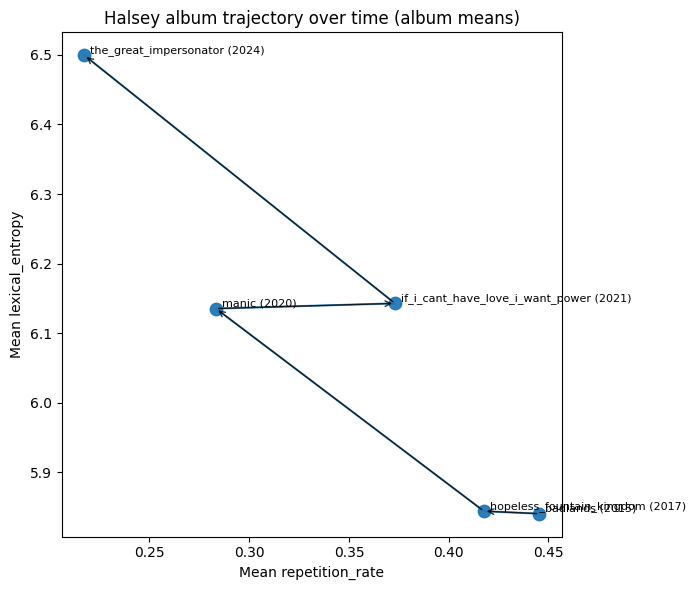

,album,year
0,badlands,2015.0
1,hopeless_fountain_kingdom,2017.0
3,manic,2020.0
2,if_i_cant_have_love_i_want_power,2021.0
4,the_great_impersonator,2024.0


In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# assumes you already did:
# df["text_type"] = ...
# df["artist_group"] = df["album"].apply(classify_artist)

def plot_halsey_album_trajectory(df,
                              x="repetition_rate",
                              y="lexical_entropy",
                              album_col="album",
                              year_col="year",
                              artist_col="artist_group",
                              label_col="album",
                              show_arrows=True,
                              annotate=True):

    halsey = df.copy()
    halsey = halsey[halsey[artist_col] == "halsey"].dropna(subset=[album_col, year_col, x, y])

    halsey[year_col] = pd.to_numeric(halsey[year_col], errors="coerce")
    halsey = halsey.dropna(subset=[year_col])

    # album-level means (one point per album)
    album_means = (
        halsey.groupby([album_col, year_col])[[x, y]]
            .mean()
            .reset_index()
            .sort_values([year_col, album_col])
    )

    plt.figure(figsize=(7, 6))

    # points + connecting path
    plt.scatter(album_means[x], album_means[y], s=80, alpha=0.95)
    plt.plot(album_means[x].values, album_means[y].values, alpha=0.8)

    # arrows for direction
    if show_arrows and len(album_means) >= 2:
        for i in range(len(album_means) - 1):
            x0, y0 = album_means.iloc[i][x], album_means.iloc[i][y]
            x1, y1 = album_means.iloc[i+1][x], album_means.iloc[i+1][y]
            plt.annotate("", xy=(x1, y1), xytext=(x0, y0),
                         arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8))

    # labels
    if annotate:
        for _, r in album_means.iterrows():
            yr = int(r[year_col])
            plt.text(r[x] + 0.003, r[y] + 0.003, f"{r[label_col]} ({yr})", fontsize=8)

    plt.xlabel(f"Mean {x}")
    plt.ylabel(f"Mean {y}")
    plt.title("Halsey album trajectory over time (album means)")
    plt.tight_layout()
    plt.show()

    return album_means

halsey_album_means = plot_halsey_album_trajectory(df)
halsey_album_means[["album", "year"]]



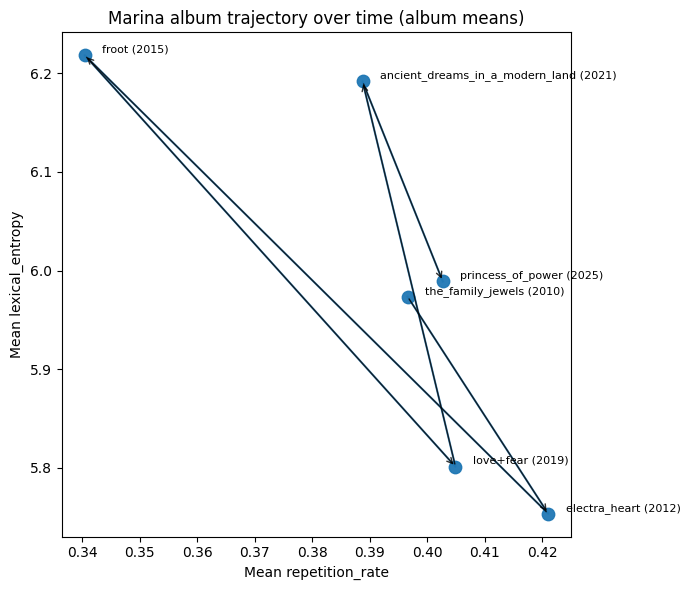

,album,year
5,the_family_jewels,2010.0
1,electra_heart,2012.0
2,froot,2015.0
3,love+fear,2019.0
0,ancient_dreams_in_a_modern_land,2021.0
4,princess_of_power,2025.0


In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# assumes you already did:
# df["text_type"] = ...
# df["artist_group"] = df["album"].apply(classify_artist)

def plot_marina_album_trajectory(df,
                              x="repetition_rate",
                              y="lexical_entropy",
                              album_col="album",
                              year_col="year",
                              artist_col="artist_group",
                              label_col="album",
                              show_arrows=True,
                              annotate=True):

    marina = df.copy()
    marina = marina[marina[artist_col] == "marina"].dropna(subset=[album_col, year_col, x, y])

    marina[year_col] = pd.to_numeric(marina[year_col], errors="coerce")
    marina = marina.dropna(subset=[year_col])

    # album-level means (one point per album)
    album_means = (
        marina.groupby([album_col, year_col])[[x, y]]
            .mean()
            .reset_index()
            .sort_values([year_col, album_col])
    )

    plt.figure(figsize=(7, 6))

    # points + connecting path
    plt.scatter(album_means[x], album_means[y], s=80, alpha=0.95)
    plt.plot(album_means[x].values, album_means[y].values, alpha=0.8)

    # arrows for direction
    if show_arrows and len(album_means) >= 2:
        for i in range(len(album_means) - 1):
            x0, y0 = album_means.iloc[i][x], album_means.iloc[i][y]
            x1, y1 = album_means.iloc[i+1][x], album_means.iloc[i+1][y]
            plt.annotate("", xy=(x1, y1), xytext=(x0, y0),
                         arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8))

    # labels
    if annotate:
        for _, r in album_means.iterrows():
            yr = int(r[year_col])
            plt.text(r[x] + 0.003, r[y] + 0.003, f"{r[label_col]} ({yr})", fontsize=8)

    plt.xlabel(f"Mean {x}")
    plt.ylabel(f"Mean {y}")
    plt.title("Marina album trajectory over time (album means)")
    plt.tight_layout()
    plt.show()

    return album_means

marina_album_means = plot_marina_album_trajectory(df)
marina_album_means[["album", "year"]]



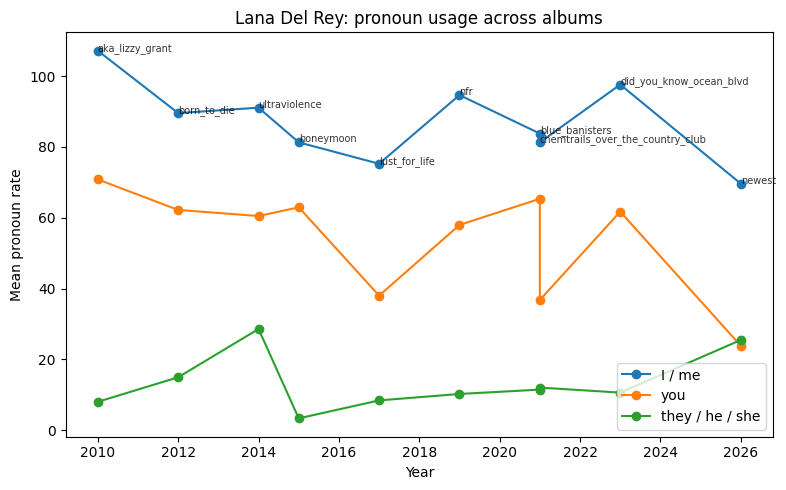

,album,year,first_person_rate,second_person_rate,third_person_rate
0,aka_lizzy_grant,2010.0,107.168077,70.827231,8.037923
2,born_to_die,2012.0,89.553733,62.215133,14.972067
9,ultraviolence,2014.0,91.086571,60.496571,28.596643
5,honeymoon,2015.0,81.301286,62.954500,3.374071
6,lust_for_life,2017.0,75.247375,38.017313,8.438125
8,nfr,2019.0,94.642692,57.973077,10.257462
1,blue_banisters,2021.0,83.780214,65.364643,11.485071
3,chemtrails_over_the_country_club,2021.0,81.291364,36.794818,12.055909
4,did_you_know_ocean_blvd,2023.0,97.612813,61.726375,10.639750
7,newest,2026.0,69.638750,23.867500,25.495500


In [61]:
def plot_lana_pronouns_over_time(df):
    lana = (
        df[df["artist_group"] == "lana"]
        .dropna(subset=[
            "album", "year",
            "first_person_rate",
            "second_person_rate",
            "third_person_rate"
        ])
        .copy()
    )

    lana["year"] = pd.to_numeric(lana["year"], errors="coerce")
    lana = lana.dropna(subset=["year"])

    album_means = (
        lana.groupby(["album", "year"])[
            ["first_person_rate", "second_person_rate", "third_person_rate"]
        ]
        .mean()
        .reset_index()
        .sort_values(["year", "album"])
    )

    plt.figure(figsize=(8, 5))

    plt.plot(album_means["year"], album_means["first_person_rate"], marker="o", label="I / me")
    plt.plot(album_means["year"], album_means["second_person_rate"], marker="o", label="you")
    plt.plot(album_means["year"], album_means["third_person_rate"], marker="o", label="they / he / she")

    for _, r in album_means.iterrows():
        plt.text(r["year"], r["first_person_rate"], r["album"], fontsize=7, alpha=0.8)

    plt.xlabel("Year")
    plt.ylabel("Mean pronoun rate")
    plt.title("Lana Del Rey: pronoun usage across albums")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return album_means

plot_lana_pronouns_over_time(df)


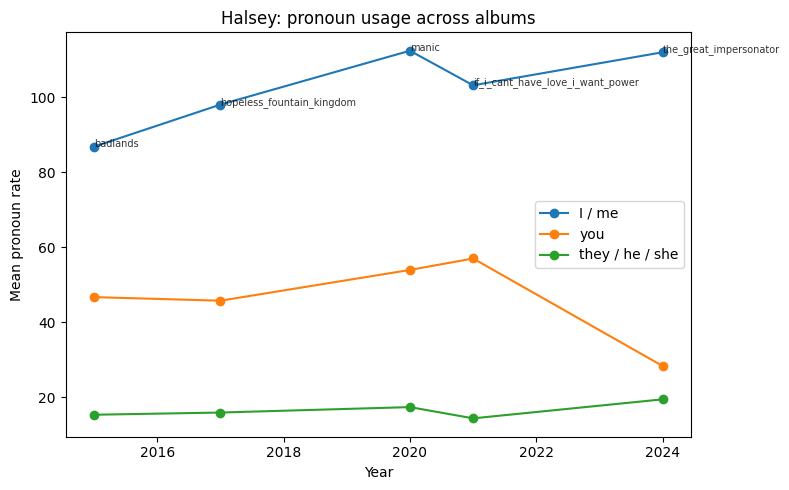

,album,year,first_person_rate,second_person_rate,third_person_rate
0,badlands,2015.0,86.801063,46.694250,15.345250
1,hopeless_fountain_kingdom,2017.0,98.001437,45.736937,15.931313
3,manic,2020.0,112.362278,53.936500,17.380056
2,if_i_cant_have_love_i_want_power,2021.0,103.144429,56.987357,14.385357
4,the_great_impersonator,2024.0,111.951611,28.336833,19.449556


In [39]:
def plot_halsey_pronouns_over_time(df):
    halsey = (
        df[df["artist_group"] == "halsey"]
        .dropna(subset=[
            "album", "year",
            "first_person_rate",
            "second_person_rate",
            "third_person_rate"
        ])
        .copy()
    )

    halsey["year"] = pd.to_numeric(halsey["year"], errors="coerce")
    halsey = halsey.dropna(subset=["year"])

    album_means = (
        halsey.groupby(["album", "year"])[
            ["first_person_rate", "second_person_rate", "third_person_rate"]
        ]
        .mean()
        .reset_index()
        .sort_values(["year", "album"])
    )

    plt.figure(figsize=(8, 5))

    plt.plot(album_means["year"], album_means["first_person_rate"], marker="o", label="I / me")
    plt.plot(album_means["year"], album_means["second_person_rate"], marker="o", label="you")
    plt.plot(album_means["year"], album_means["third_person_rate"], marker="o", label="they / he / she")

    for _, r in album_means.iterrows():
        plt.text(r["year"], r["first_person_rate"], r["album"], fontsize=7, alpha=0.8)

    plt.xlabel("Year")
    plt.ylabel("Mean pronoun rate")
    plt.title("Halsey: pronoun usage across albums")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return album_means

plot_halsey_pronouns_over_time(df)


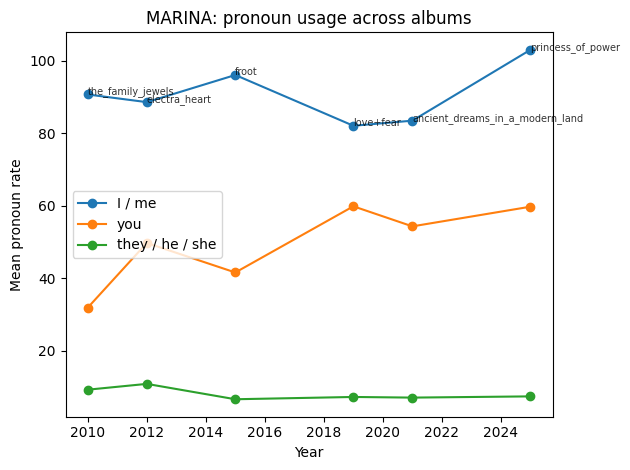

,album,year,first_person_rate,second_person_rate,third_person_rate
5,the_family_jewels,2010.0,90.716071,31.944143,9.316643
1,electra_heart,2012.0,88.603789,49.769737,10.917368
2,froot,2015.0,96.089333,41.635333,6.680917
3,love+fear,2019.0,82.092938,59.884188,7.311250
0,ancient_dreams_in_a_modern_land,2021.0,83.496231,54.352769,7.134769
4,princess_of_power,2025.0,103.034706,59.775059,7.472176


In [41]:
def plot_marina_pronouns_over_time(df):
    marina = (
        df[df["artist_group"] == "marina"]
        .dropna(subset=[
            "album", "year",
            "first_person_rate",
            "second_person_rate",
            "third_person_rate"
        ])
        .copy()
    )

    marina["year"] = pd.to_numeric(marina["year"], errors="coerce")
    marina = marina.dropna(subset=["year"])

    album_means = (
        marina.groupby(["album", "year"])[
            ["first_person_rate", "second_person_rate", "third_person_rate"]
        ]
        .mean()
        .reset_index()
        .sort_values(["year", "album"])
    )

    plt.figure(figsize=(8, 5))

    plt.plot(album_means["year"], album_means["first_person_rate"], marker="o", label="I / me")
    plt.plot(album_means["year"], album_means["second_person_rate"], marker="o", label="you")
    plt.plot(album_means["year"], album_means["third_person_rate"], marker="o", label="they / he / she")

    for _, r in album_means.iterrows():
        plt.text(r["year"], r["first_person_rate"], r["album"], fontsize=7, alpha=0.8)

    plt.xlabel("Year")
    plt.ylabel("Mean pronoun rate")
    plt.title("MARINA: pronoun usage across albums")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return album_means

plot_marina_pronouns_over_time(df)


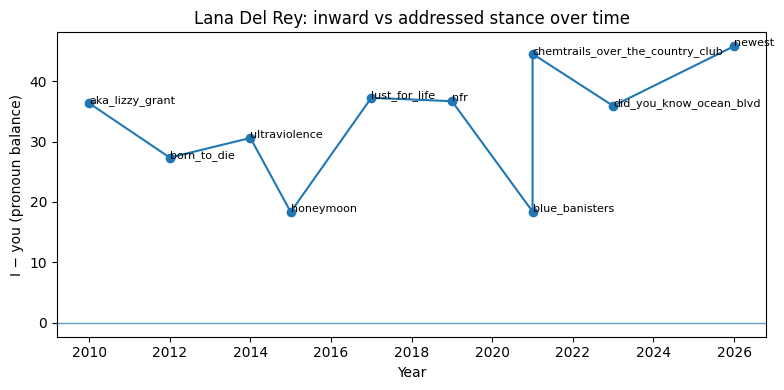

,album,year,first_person_rate,second_person_rate,third_person_rate,I_minus_you
0,aka_lizzy_grant,2010.0,107.168077,70.827231,8.037923,36.340846
2,born_to_die,2012.0,89.553733,62.215133,14.972067,27.338600
9,ultraviolence,2014.0,91.086571,60.496571,28.596643,30.590000
5,honeymoon,2015.0,81.301286,62.954500,3.374071,18.346786
6,lust_for_life,2017.0,75.247375,38.017313,8.438125,37.230063
8,nfr,2019.0,94.642692,57.973077,10.257462,36.669615
1,blue_banisters,2021.0,83.780214,65.364643,11.485071,18.415571
3,chemtrails_over_the_country_club,2021.0,81.291364,36.794818,12.055909,44.496545
4,did_you_know_ocean_blvd,2023.0,97.612813,61.726375,10.639750,35.886438
7,newest,2026.0,69.638750,23.867500,25.495500,45.771250


In [62]:
def plot_lana_pronoun_balance(df):
    lana = (
        df[df["artist_group"] == "lana"]
        .dropna(subset=[
            "album", "year",
            "first_person_rate",
            "second_person_rate",
            "third_person_rate"
        ])
        .copy()
    )

    lana["year"] = pd.to_numeric(lana["year"], errors="coerce")
    lana = lana.dropna(subset=["year"])

    album_means = (
        lana.groupby(["album", "year"])[
            ["first_person_rate", "second_person_rate", "third_person_rate"]
        ]
        .mean()
        .reset_index()
        .sort_values(["year", "album"])
    )

    # balance: inwardness minus address
    album_means["I_minus_you"] = (
        album_means["first_person_rate"]
        - album_means["second_person_rate"]
    )

    plt.figure(figsize=(8, 4))
    plt.plot(album_means["year"], album_means["I_minus_you"], marker="o")
    plt.axhline(0, lw=1, alpha=0.7)

    for _, r in album_means.iterrows():
        plt.text(r["year"], r["I_minus_you"], r["album"], fontsize=8)

    plt.xlabel("Year")
    plt.ylabel("I − you (pronoun balance)")
    plt.title("Lana Del Rey: inward vs addressed stance over time")
    plt.tight_layout()
    plt.show()

    return album_means

plot_lana_pronoun_balance(df)
